In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
#import tqdm
from src import models, utils#, parametrizations,tasks,running#,tasks
import os 

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    'font.size': 25,  # Update global font size
    'axes.titlesize': 20,  # Update axes title font size
    'axes.labelsize': 10,  # Update axes label font size
    'xtick.labelsize': 20,  # Update xtick label font size
    'ytick.labelsize': 20,  # Update ytick label font size
})
plt.style.use("seaborn-poster")

/tmp/ipykernel_2711618/2815468151.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


In [335]:
def run_subspace_adaptation(net = None, hidden_size = 32, p = 5, dt = 0.005, T = 150, trials = 1 , eta = 1, gain = 1, sigma = 5, amp = 1, lam = 1, Q = None):

    n = int(net.hidden_size*net.p)
    ts = np.arange(0, T, dt)

    es = np.zeros((trials,len(ts)))

    all_states = []

    for trial in range(trials):

        net.A = np.eye(n)*net.B

        x = np.random.normal(0, 1, n)

        #_, sine_waves = generate_sine_waves(n, T, time_step= dt, frequency = 2)
        u = utils.generate_GP(T = T, time_step = 0.1, n = n, sigma = sigma)
        u = utils.upscale_timeseries(u.T, len(ts))
        u = amp*u.T       
       
        states = []

        for k, _ in enumerate(ts):
            
            states.append(x)

            e = (Q.T @ Q) @ x #x - #xs_d[:,k]
            es[trial,k] = np.linalg.norm(Q @ x) #np.dot(e,e)/np.linalg.norm(Q,ord = 'fro')       

            net.A = net.A + dt*(-lam*net.A - eta*np.outer(e,np.maximum(0,net.D@x))*net.B)
            f = net(x, u[:,k] - gain*e)            

            x = x +  dt*f

        states = np.stack(states)
        
        all_states.append(states)

    
        
    
    return es, all_states, u, ts
    

In [311]:
def gram_schmidt(A):
    Q = np.zeros_like(A, dtype=np.float64)
    for i in range(A.shape[1]):
        # orthogonalize
        Q[:, i] = A[:, i]
        for j in range(i):
            Q[:, i] -= Q[:, j].dot(A[:, i]) * Q[:, j]
        # normalize
        Q[:, i] /= np.linalg.norm(Q[:, i])
    return Q

def generate_orthonormal_matrix(n, m):
    assert n >= m, "n should be greater than or equal to m"
    A = np.random.rand(n, m)
    Q = gram_schmidt(A)
    return Q.T




In [424]:
hidden_size = 32
p = 10

subspace_dim = 5
m = hidden_size*p - subspace_dim

Q = generate_orthonormal_matrix(hidden_size*p, m)



GW_RNN_Stable = models.GW_Net(g = 2.5, s_max = 2.5, hidden_size = hidden_size, p = p, arch = 'random')
es_q,states_q,u_q,ts_q = run_subspace_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.05, eta = 1, gain = 1, lam = 0, sigma = 5, amp = 0.0, trials = 10, Q = Q)


GW_RNN_Stable = models.GW_Net(g = 2.5, s_max = 2.5, hidden_size = hidden_size, p = p, arch = 'random')
es,states,u,ts = run_subspace_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.05, eta = 0, gain = 0, lam = 0, sigma = 5, amp = 0.0, trials = 10, Q = Q)

In [425]:
from sklearn.decomposition import PCA

pcas_q = []
pcas = []

for i in range(10):

    pca_q = PCA(n_components=10)

    pca_q.fit(states_q[i])

    pcas_q.append(pca_q.explained_variance_ratio_[0:10])


    pca = PCA(n_components=10)

    pca.fit(states[i])

    pcas.append(pca.explained_variance_ratio_[0:10])

pcas_q = np.stack(pcas_q)
pcas = np.stack(pcas)
#plt.plot(states[:,0])
#plt.legend()

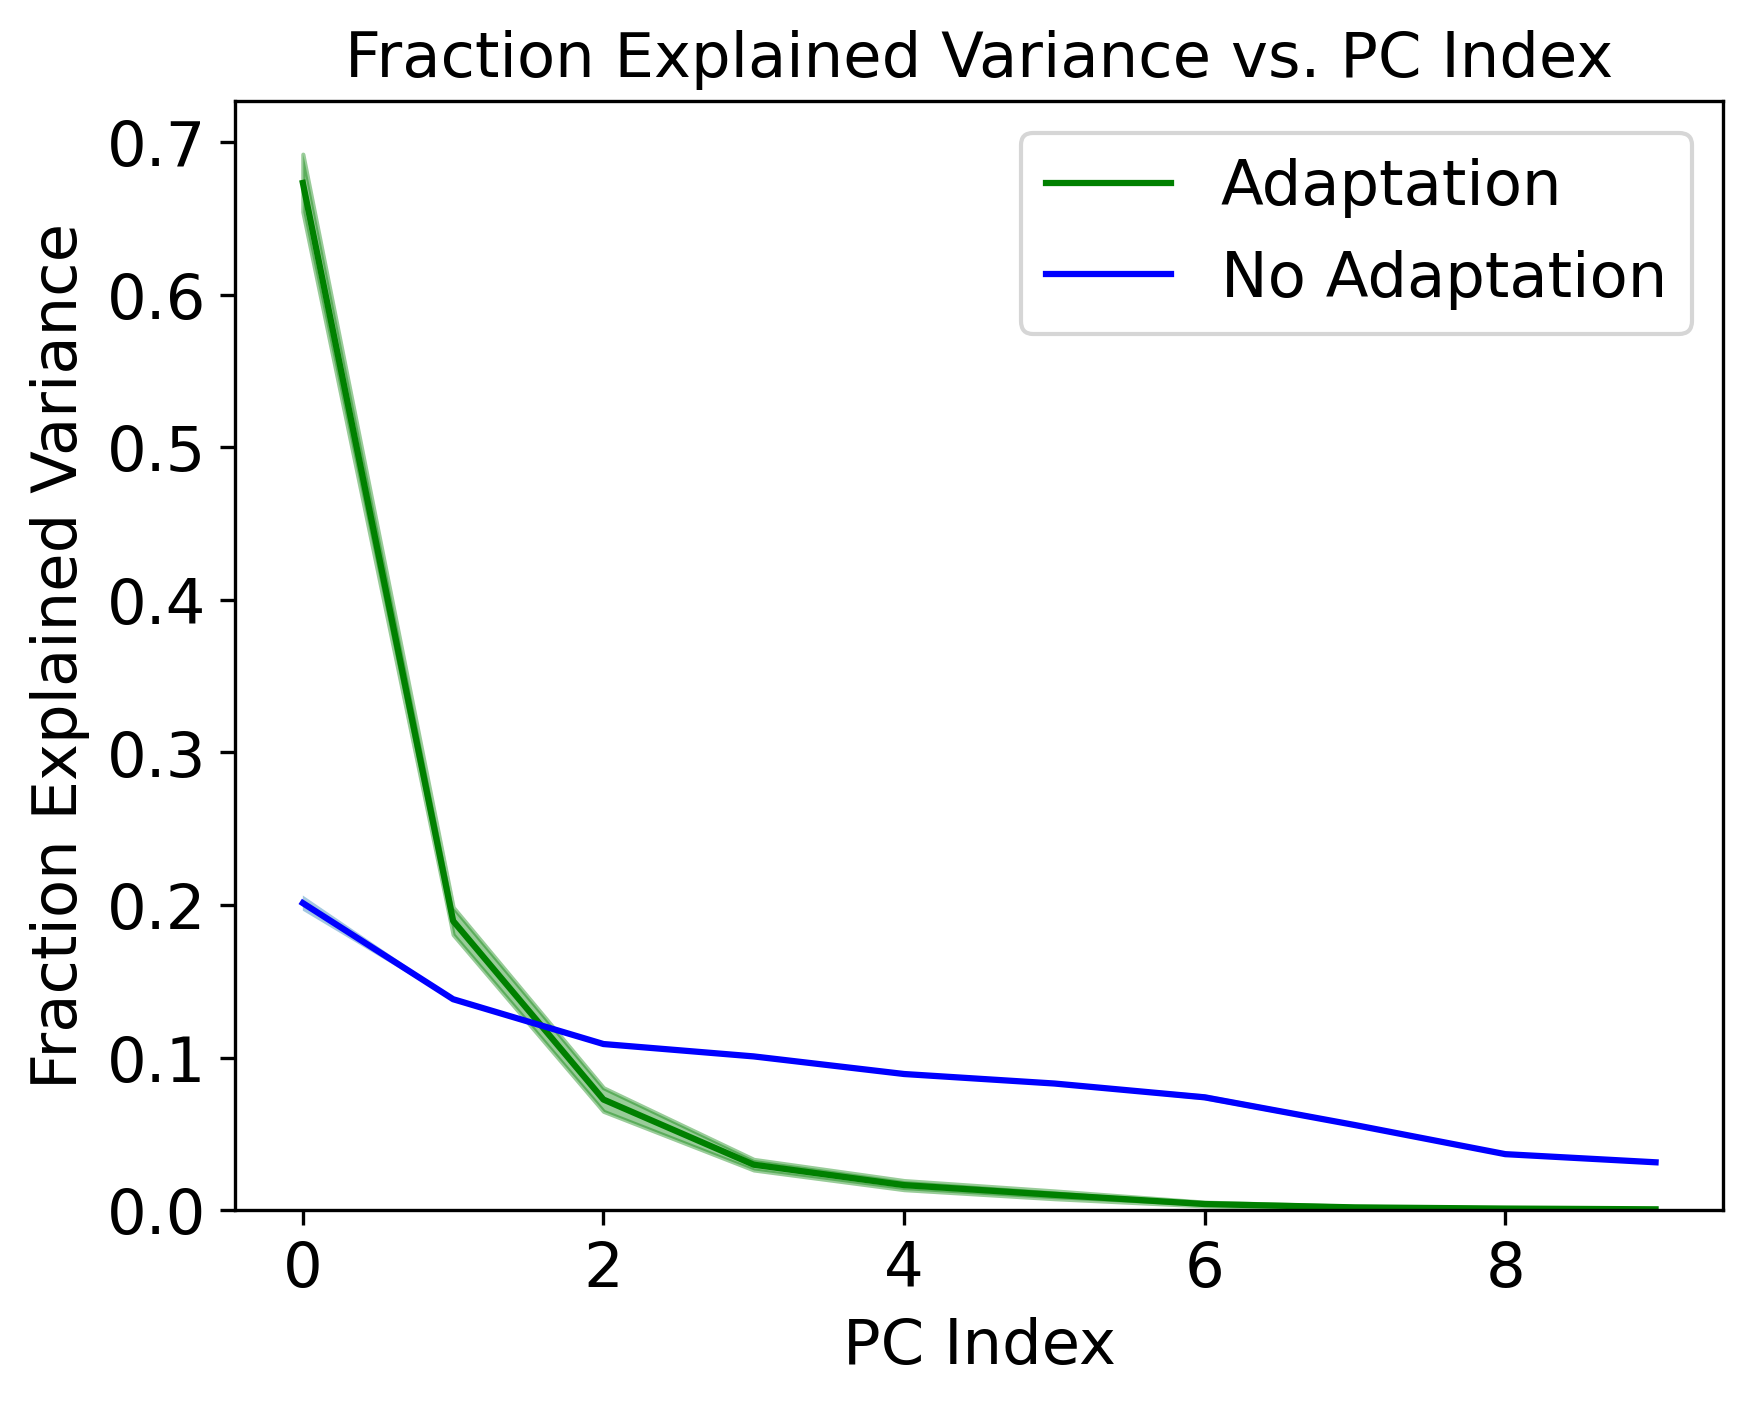

In [441]:
plt.style.use("default")

fig = plt.figure(dpi = 300)
plt.rcParams.update({
    'font.size': 25,  # Update global font size
    'axes.titlesize': 15,  # Update axes title font size
    'axes.labelsize': 15,  # Update axes label font size
    'xtick.labelsize': 15,  # Update xtick label font size
    'ytick.labelsize': 15,  # Update ytick label font size
})

mean_e = np.mean(pcas_q, axis = 0)
std_e = np.std(pcas_q, axis = 0)
standard_error = std_e/np.sqrt(10)
pc_inds = range(10)
plt.plot(pc_inds,mean_e,color = 'g', label='Adaptation')
plt.fill_between(pc_inds,mean_e - standard_error, mean_e + standard_error, alpha=0.4, color = 'g')
plt.ylim(0)


mean_e = np.mean(pcas, axis = 0)
std_e = np.std(pcas, axis = 0)
standard_error = std_e/np.sqrt(10)
pc_inds = range(10)
plt.plot(pc_inds,mean_e,color = 'b', label='No Adaptation')
plt.fill_between(pc_inds,mean_e - standard_error, mean_e + standard_error, alpha=0.4)

plt.legend(fontsize = 15)


plt.xlabel('PC Index')
plt.ylabel('Fraction Explained Variance')
plt.title('Fraction Explained Variance vs. PC Index')


plt.savefig('/home/leo/rnns-of-rnns/results/plots/pca_subspace.png',dpi = 300)

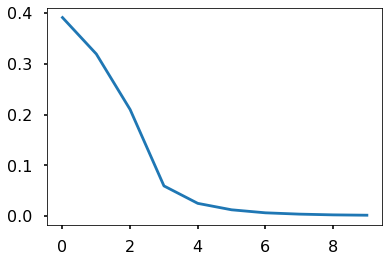

In [352]:
plt.plot(mean_e+standard_error)

In [267]:
np.sum(pca.explained_variance_ratio_[0:m])/np.sum(pca_q.explained_variance_ratio_[0:m])

1.051090240149839